<a href="https://colab.research.google.com/github/alexc6h6/Image-Classification-CNN/blob/master/Project_Plant_Seedlings_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant Seedlings Classification

Applying artificial intelligence increase of agricultural yields in an affordable way, in a short period, and with minimal human labor required. By using camera facilitate in the drone catches image for plant seedling and classifies by CNN to ckeck whether the plant seedling is the plant that would be growed or not.

The dataset are provided from Kaggle by The Aarhus University Signal Processing group. There are 12 species of plants at several growth stages. 

Each image contain plant and background with sand and rocks which might be the noise for Convolution neuron networks.

![alt text](https://storage.googleapis.com/kaggle-media/competitions/seedlings-classify/seedlings.png)

To generate the certain channel mask to cover the noice to increase accuracy in model training.

In [0]:
#!pip install --upgrade tensorflow

In [2]:
from google.colab import drive, files

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from keras.preprocessing import image
import os
from glob import glob
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

print(tf.__version__)

Using TensorFlow backend.


2.2.0


In [4]:
!ls '/content/drive/My Drive/plant-seedlings-classification'

sample_submission.csv  test  train


In [0]:
def images_labels(folder_path, images, labels):
  for class_folder in os.listdir(folder_path):
    class_folder_path = os.path.join(folder_path, class_folder)
    for image_path in glob(os.path.join(class_folder_path, '*.png')):
      img = cv2.imread(image_path, cv2.IMREAD_COLOR)
      img = cv2.resize(img, (128, 128))

      images.append(img)
      labels.append(class_folder)

  images = np.array(images)
  labels = np.array(labels)

  return images, labels

In [0]:
#load image dataset, tranfer image to array
train_folder_path = '/content/drive/My Drive/plant-seedlings-classification/train'
train_images = []
train_labels = []

train_images, train_labels = images_labels(train_folder_path, train_images, train_labels)

In [7]:
print('image array shape')
print(train_images.shape)
print('label array shape')
print(train_labels.shape)


image array shape
(4750, 128, 128, 3)
label array shape
(4750,)


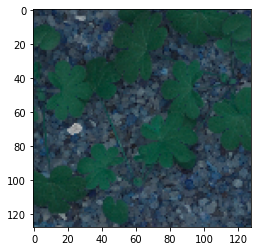

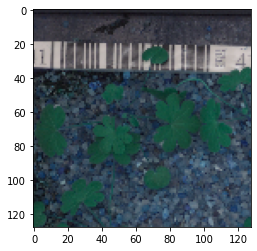

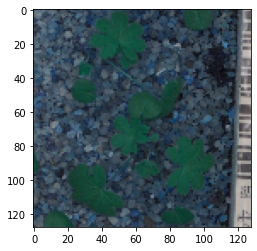

In [8]:
#print images
#there is some sand and rock on the background. It could be noicy when CNN extract the feature from image.
for image in train_images[:3]:
  plt.imshow(image)
  plt.show()


In [0]:
#create a mask to cover the background
def masked_images(masked_images, images):
  for image in images:
    blur = cv2.GaussianBlur(image, (5,5), 0) #blurred
    hsv = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)  #hsv converted
    lower = (25, 43, 46)
    upper = (77, 255, 255)
    mask = cv2.inRange(hsv, lower, upper)  #masked
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, struc)
    boolean = mask > 0  #boolean masked
    new = np.zeros_like(image, np.uint64) 
    new[boolean] = image[boolean]  #new modified image
    masked_images.append(new)

  masked_images = np.asarray(masked_images)

  return masked_images

In [0]:
train_masked_images = []

train_masked_images = masked_images(train_masked_images, train_images)

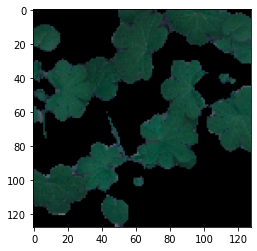

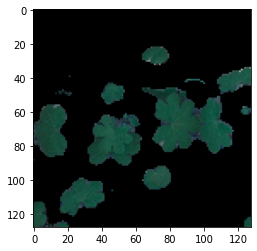

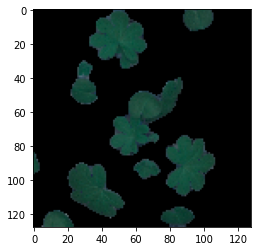

In [11]:
for image in train_masked_images[:3]:
  plt.imshow(image)
  plt.show()

In [12]:
#normalize image dataset
train_masked_images = train_masked_images/255

print(train_masked_images.shape)

(4750, 128, 128, 3)


In [13]:
#transform label into one_hot code label
le = LabelEncoder()
train_num_labels = le.fit_transform(train_labels)
ohe = OneHotEncoder(categories = 'auto')
train_ohe_labels = ohe.fit_transform(train_num_labels.reshape(-1, 1)).toarray()

print(train_ohe_labels.shape)

(4750, 12)


In [0]:
#split dataset into training set and validation set
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(train_masked_images, train_ohe_labels, test_size = 0.1)

In [0]:
#generate more data for training by using ImageDataGenerator

datagen = ImageDataGenerator(rotation_range = 180, width_shift_range = 0.1, height_shift_range = 0.1,
                             zoom_range = 0.1, shear_range = 0.1, horizontal_flip = True, vertical_flip = True)

datagen.fit(x_train)

In [16]:
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same',
                                                           strides = 1, input_shape = (128, 128, 3)),
                                    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same',
                                                           strides = 1),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D((2,2)),
                                    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same',
                                                           strides = 1),
                                    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same',
                                                           strides = 1),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D((2,2)),
                                    tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', padding = 'same',
                                                           strides = 1),
                                    tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', padding = 'same',
                                                           strides = 1),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D((2,2)),
                                    tf.keras.layers.Conv2D(512, (3,3), activation = 'relu', padding = 'same',
                                                           strides = 1),
                                    tf.keras.layers.Conv2D(512, (3,3), activation = 'relu', padding = 'same',
                                                           strides = 1),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D((2,2)),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dropout(0.3),
                                    tf.keras.layers.Dense(512),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.Dropout(0.3),
                                    tf.keras.layers.Dense(12, activation = 'softmax')])

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 128)       5

In [0]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', patience = 8, min_lr = 0.00000001, verbose = 1)

In [18]:
batch = 64
epoch = 75

history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch),
                              steps_per_epoch = len(x_train)/batch, 
                              epochs = epoch,
                              validation_data = (x_val, y_val),
                              verbose = 1,
                              callbacks = [reduce_lr])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/75
67/66 [==============================] - 19s 280ms/step - loss: 1.5875 - acc: 0.4814 - val_loss: 3.9332 - val_acc: 0.0800 - lr: 0.0010
Epoch 2/75
67/66 [==============================] - 17s 250ms/step - loss: 1.0176 - acc: 0.6480 - val_loss: 4.7143 - val_acc: 0.1558 - lr: 0.0010
Epoch 3/75
67/66 [==============================] - 17s 252ms/step - loss: 0.7868 - acc: 0.7270 - val_loss: 8.6937 - val_acc: 0.0947 - lr: 0.0010
Epoch 4/75
67/66 [==============================] - 17s 251ms/step - loss: 0.6756 - acc: 0.7647 - val_loss: 13.1411 - val_acc: 0.0589 - lr: 0.0010
Epoch 5/75
67/66 [==============================] - 17s 252ms/step - loss: 0.5702 - acc: 0.8044 - val_loss: 15.0287 - val_acc: 0.0589 - lr: 0.0010
Epoch 6/75
67/66 [==============================] - 17s 252ms/step - loss: 0.5039 - acc: 0.8299 - val_loss: 16.8293 - val_acc: 0.0884 - lr: 0.0010
Epoch 7/75
67/66 [===========================

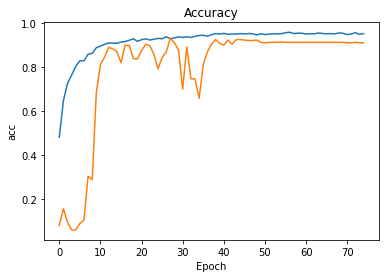

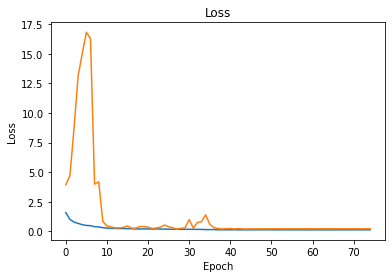

Accuracy: 0.9115789532661438%
Loss: 0.2239464819431305


In [35]:
#plot training accuracy and loss
def show_train_history_acc(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('acc')
    plt.show()

def show_train_history_loss(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

show_train_history_acc(history)
show_train_history_loss(history)

print('Accuracy: ' + str(history.history['val_acc'][-1]) + '%')
print('Loss: ' + str(history.history['val_loss'][-1]))

In [0]:
model.save('/content/drive/My Drive/seedling_model.h5')